In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer


from sklearn import metrics
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import (
    Ridge,RidgeCV,
    Lasso,LassoCV,
    ElasticNet, ElasticNetCV,
    LinearRegression
)
from sklearn.model_selection import(
    cross_val_score,
    train_test_split
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
# pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_columns', 50)  # or 1000

In [3]:
train = pd.read_csv('../data/train_cleaned.csv')
weather = pd.read_csv('../data/weather_cleaned.csv')

# Contents
- [Cleaning Train Dataset](#Cleaning-Train-Dataset)
- [Cleaning Test Dataset](#Cleaning-Test-Dataset)
- [Cleaning Weather Dataset](#Cleaning-Weather-Dataset)
- [Cleaning Spray Dataset](#Cleaning-Spray-Dataset)

In [4]:
merge_train_weather = train.merge(weather, on = 'date', how = 'inner')

In [5]:
merge_train_weather.columns

Index(['Unnamed: 0_x', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvcount', 'wnvpresent', 'date_col', 'Unnamed: 0_y',
       'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed', 'sunrise', 'sunset', 'bc', 'br', 'dz', 'fg', 'fg+', 'fu',
       'gr', 'hz', 'mi', 'ra', 'sn', 'sq', 'ts', 'vc'],
      dtype='object')

In [6]:
merge_train_weather.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y'], inplace = True)

In [7]:
merge_train_weather['date'] = pd.to_datetime(merge_train_weather['date'])
merge_train_weather['year'] = merge_train_weather['date'].dt.year
merge_train_weather['month'] = merge_train_weather['date'].dt.month

Text(0, 0.5, 'Temperature')

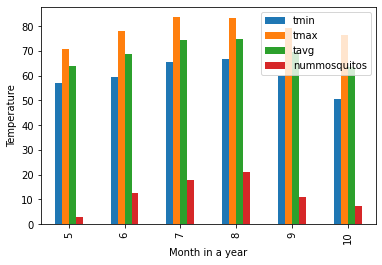

In [21]:
# monthly trend of average temperature
merge_train_weather.groupby('month').mean()[['tmin', 'tmax', 'tavg', 'nummosquitos']].plot.bar()
plt.xlabel('Month in a year')
plt.ylabel('Temperature')

We can see increasing trend in temperature over the months, typically highest on August

In [10]:
# monthly trend of average temperature
merge_train_weather.groupby('month').mean()[['heat', 'cool']]

,heat,cool
month,,
5,4.148148,3.240741
6,1.926328,5.905759
7,0.067271,9.858540
8,0.008909,10.282545
9,2.310221,7.043914
10,3.454545,2.399621


This should not be in continuous variable analysis as it depicts average cooling or heating component during hot and cold seasons. 
Naturally if we see on August having very high temp, for sure heating will be set at zero and cooling will be set at max. As temperature is believe to be a crucial factor to mosquito activity based ([source](https://blog.mosquito.buzz/how-weather-affects-mosquito-activity)), the higher the temp, the higher the cooling effect needed to dampen the overall temp, displaying positive correlation. It will not make sense to compare with the number of mosquitos as it will sure show positive correlation of cooling effect to num of mosquitos. Hence we remove it. 



In [11]:
continuous_var = ['tavg','dewpoint','wetbulb','preciptotal','stnpressure','sealevel','resultspeed',
 'resultdir','avgspeed','br','dz','fg','hz','ra','ts','nummosquitos']

In [12]:
impt_features = merge_train_weather[continuous_var]

In [13]:
# defining lasso regression to better book kepe journal.
# outputs are X_train, X_test, y_train, y_test, lasso_best
# included indices as well in order to find outliers 

def lasso_reg(X_df,y_series,test_size):
    # assign X and y

    X = X_df
    y = y_series
    indices = X_df.index.values
    
    # Create train/test splits.
    X_train, X_test, y_train, y_test,indices_train, indices_test = train_test_split(
        X,
        y,
        indices,
        test_size=test_size,
        random_state = 123
    )

    # Scale our data.
    # Relabeling scaled data as "Z" is common.
    sc = StandardScaler()
    # Z_train = sc.fit_transform(X_train)
    sc.fit(X_train) # fit should only see train data, 
                    #else if put in test, will have leak from the train data 
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)

    # initiate 
    lasso = LassoCV(
        cv=5,
        max_iter=90000,
        n_alphas=200,
    )

    # Fit model using best ridge alpha!
    lasso.fit(X_train, y_train);

    #fit lasso best with alpha 
    lasso_best = Lasso(alpha = lasso.alpha_)

    # fit lasso best 
    lasso_best.fit(X_train,y_train)

    # cross val mse
    cross_score = - cross_val_score(
        lasso_best,
        X_train,
        y_train,
        cv = 3,
        scoring = 'neg_mean_squared_error'
    ).mean()

    # test mse
    mse_test = mean_squared_error(
        y_test,
        lasso_best.predict(X_test)
    )
    # cross - test 
    mse_train_minus_test = cross_score - mse_test

    if mse_train_minus_test > 0:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Underfited by: {mse_train_minus_test}')
    else:
        print(f'MSE for train: {cross_score}')
        print(f'MSE for test: {mse_test}')
        print(f'Overfitted by: {mse_train_minus_test}')
    print(f'RMSE: {mse_test**0.5}')
    print(f'Lasso alpha used: {lasso.alpha_}')
    
    return X_train, X_test, y_train, y_test, lasso_best, indices_train, indices_test

In [14]:
X = impt_features.drop(columns = ['nummosquitos'])
y = impt_features['nummosquitos']

In [15]:
# redo scale and lasso 
X_train, X_test, y_train, y_test, lasso_best,indices_train, indices_test= lasso_reg(
    X_df = X,
    y_series = y,
    test_size = 0.3
)

MSE for train: 5243.644816685012
MSE for test: 6455.68955402971
Overfitted by: -1212.0447373446978
RMSE: 80.34730582931645
Lasso alpha used: 0.1962279276855757


<AxesSubplot:>

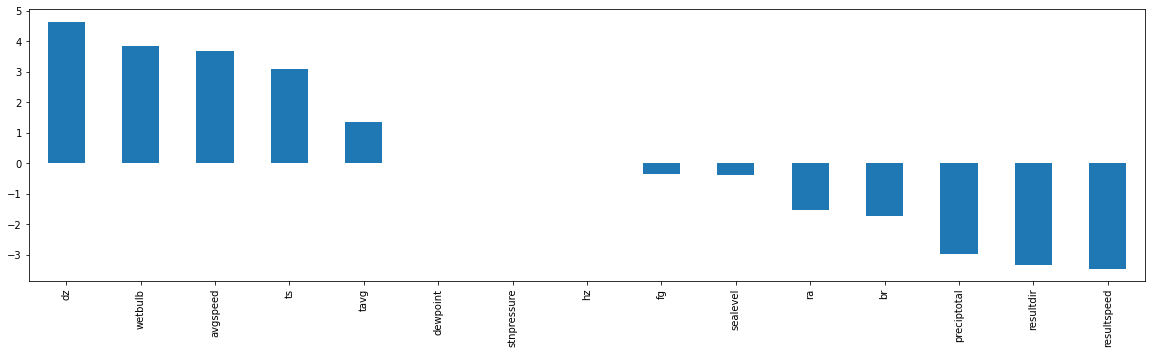

In [16]:
# to plot the series 
# too many variables, need to scale down the number of features 
plt.figure(figsize=(20,5))

col = X.columns
pd.Series(lasso_best.coef_, index = col).sort_values(ascending = False).plot.bar()

Checking code sum should only have these based on Daily Table format given by Kaggle 

`TS` - Thunderstorm

`RA` - Rain

`FG` - Fog

`FG+` - Heavy Fog 

`BR` - Mist

`DZ` - Drizzle 

`HZ` - Haze




In [17]:
heatmap_df = pd.DataFrame(impt_features)
heatmap_df = heatmap_df.rename(columns= {'ts' : 'thunderstorm', 'ra': 'rain', 'fg': 'fog', 'fg+': 'heavy_fog', 'br': 'mist', 'dz': 'drizzle', 'hz': 'haze'})

<AxesSubplot:>

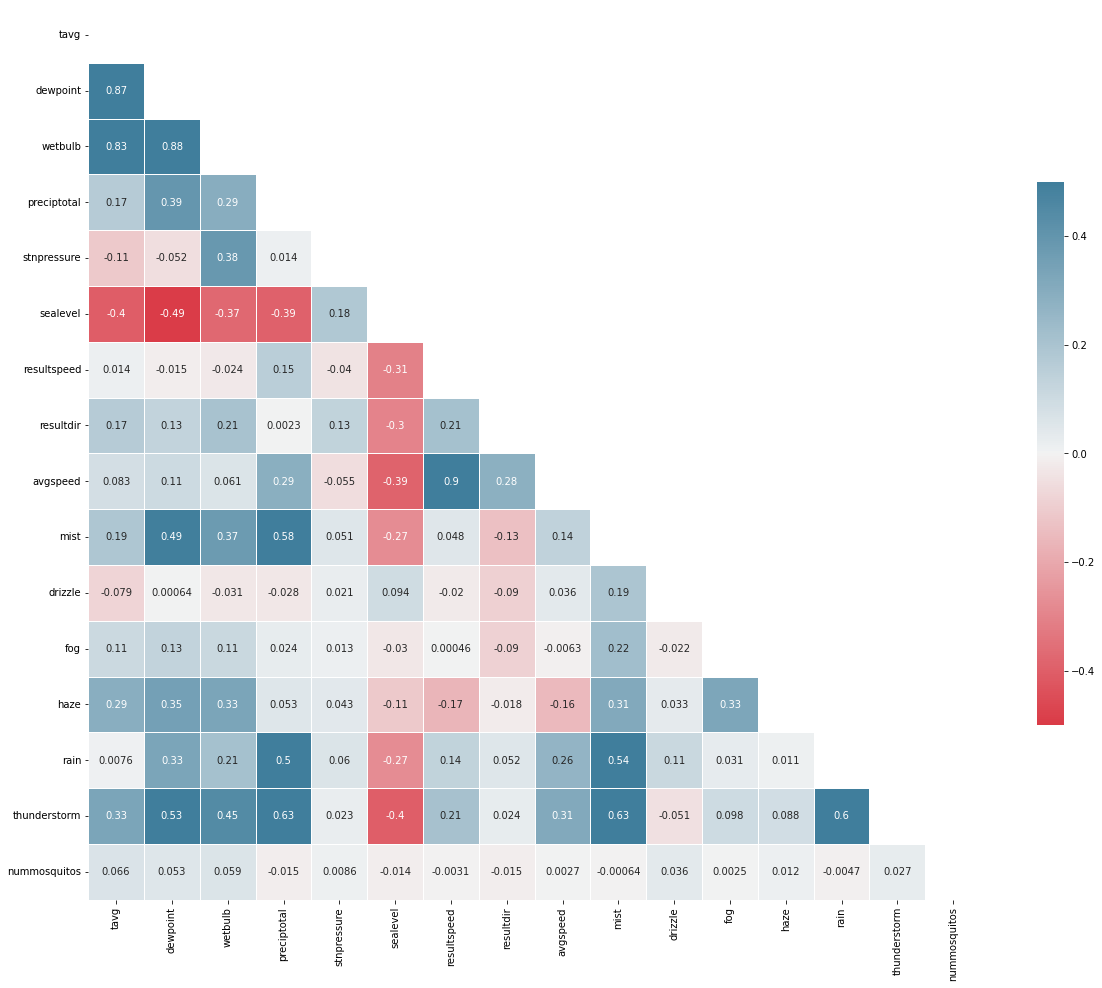

In [18]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(heatmap_df.corr()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 230, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(heatmap_df.corr(), mask=mask, cmap=cmap, vmax=0.5, vmin = -0.5,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5}, annot = True)

In [19]:
heatmap_df.corr()['nummosquitos'].sort_values(ascending = False)

nummosquitos    1.000000
tavg            0.065652
wetbulb         0.059446
dewpoint        0.052978
drizzle         0.035524
thunderstorm    0.027312
haze            0.011809
stnpressure     0.008643
avgspeed        0.002699
fog             0.002491
mist           -0.000642
resultspeed    -0.003099
rain           -0.004741
sealevel       -0.013790
preciptotal    -0.015122
resultdir      -0.015436
Name: nummosquitos, dtype: float64

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

From the heatmap, few observations were observed. 

1) Generally, having `thunderstorm`, `haze`, `fog`, `drizzle` have a positive correlation with number of mosquitoes while `heat`, `preciptotal`, `sealevel`, `resultdirection` has a slight negative correlation. These indicators will be strong in predicting if the area has a more 
2) We can see that `dewpoint` and `wetbulb` is highly correlated to `avg temperature`, suggesting that overall temperature has influence on the two variables. The `higher the dewpoint and temperature`, the `higher the relatively humidity` of the environment. Based on ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7068582/)), `humidity` shows `positive correlation` with the `numbers of species sampled from the traps`. 
3) The average speed has relative high correlation to weather conditions like `thunderstorm` and `rain` suggesting its used to help predict weather patterns and global climate. Although it might be not strongly correlated to number of mosquitos alongside witht resultspeed and resultdir, we should consider this in our modelling as based on ([source](https://kestrelmeters.com/blogs/news/the-science-of-mosquito-abatement#:~:text=Wind%20works%20as%20a%20natural,MPH%20wind%20gust%20is%20substantial)), strong wind serves as natural repellent as mosquitos cannot fly through strong wind. 

